<a href="https://colab.research.google.com/github/SergeyBryukhanov/SergeyBryukhanov/blob/main/mnist_fashion_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time

import numpy as np

# Работа с файловой системой и системными функциями
import os

# Подготовка данных
from keras import preprocessing
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Построение сети
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape, Input

# Визуализация выполнения процессов, циклов
from tqdm import tqdm

# Генерация случайных чисел
import re

# Работа с графиками
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Отключаем лишние предупреждения
import warnings
warnings.filterwarnings('ignore')

tf.config.run_functions_eagerly(True)

In [ ]:
SIZE = 28                   # линейный размер изображений (одно измерение)
INPUT_IMG = (SIZE, SIZE, 1) # размер входного изображений
BATCH_SIZE = 64             # размер пакета для обучения
LATENT_DIM = 512            # размерность латентного пространства
EPOCHS = 100
SAMPLES_COUNT = 7000

In [ ]:
(train_images, _), (_, _) = fashion_mnist.load_data()
train_images = train_images[:SAMPLES_COUNT]  # Берем первые 10 000
train_images = (train_images.astype('float32') - 127.5) / 127.5  # Нормализация [-1, 1]
train_images = np.expand_dims(train_images, axis=-1)

# Создание Dataset
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                .cache()
                .shuffle(SAMPLES_COUNT, reshuffle_each_iteration=True)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def gen(latent_dim=LATENT_DIM):
    model = Sequential([
        Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        BatchNormalization(),
        LeakyReLU(0.2),
        Reshape((7, 7, 256)),

        Conv2DTranspose(128, (5,5), strides=1, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2DTranspose(64, (5,5), strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2DTranspose(32, (5,5), strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2DTranspose(1, (5,5), strides=1, padding='same',
                       activation='tanh', use_bias=False)
    ])
    return model

def Discriminator():
    model = Sequential([
        Conv2D(32, (3,3), strides=2, padding='same', input_shape=(28, 28, 1)),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(64, (3,3), strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(128, (3,3), strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(256, (3,3), strides=1, padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def show_images(model, epoch, latent_dim, examples_to_generate=4):
    noise = tf.random.normal([examples_to_generate, latent_dim])
    predictions = model(noise, training=False)

    plt.figure(figsize=(16, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(1, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
from tqdm import tqdm  # Для красивого прогресс-бара

def train(epochs, dataset, generator, discriminator):
    # Оптимизаторы
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    # Метрики для сбора потерь
    gen_losses = []
    disc_losses = []

    @tf.function
    def train_step(images):
        noise = tf.random.normal([images.shape[0], LATENT_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        # Обновление дискриминатора
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        # Обновление генератора
        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

        return gen_loss, disc_loss

    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = []
        epoch_disc_loss = []

        # Обучение с прогресс-баром
        for image_batch in tqdm(dataset, desc=f'Epoch {epoch+1}'):
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

        # Расчет средних потерь за эпоху
        avg_gen_loss = tf.reduce_mean(epoch_gen_loss)
        avg_disc_loss = tf.reduce_mean(epoch_disc_loss)

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        # Вывод статистики
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Generator Loss: {avg_gen_loss:.4f}")
        print(f"Discriminator Loss: {avg_disc_loss:.4f}")
        print(f"Time: {time.time()-start:.2f}s")

        # Генерация примеров каждые N эпох
        if (epoch+1) % 5 == 0 or epoch == epochs-1:
            show_images(generator, epoch+1, LATENT_DIM)

    return gen_losses, disc_losses

In [ ]:
def plot_generated_images(square = 5):

  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

    plt.axis('off')
    plt.grid()

In [ ]:
generator = gen()
discriminator = Discriminator()

Epoch 1: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 1/100
Generator Loss: 1.7391
Discriminator Loss: 1.1069
Time: 82.00s


Epoch 2: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 2/100
Generator Loss: 1.6353
Discriminator Loss: 1.3067
Time: 81.91s


Epoch 3: 100%|██████████| 110/110 [00:42<00:00,  2.56it/s]



Epoch 3/100
Generator Loss: 2.0375
Discriminator Loss: 0.8966
Time: 42.97s


Epoch 4: 100%|██████████| 110/110 [00:43<00:00,  2.54it/s]



Epoch 4/100
Generator Loss: 1.6819
Discriminator Loss: 1.0258
Time: 43.28s


Epoch 5: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]



Epoch 5/100
Generator Loss: 1.5729
Discriminator Loss: 1.1215
Time: 42.27s


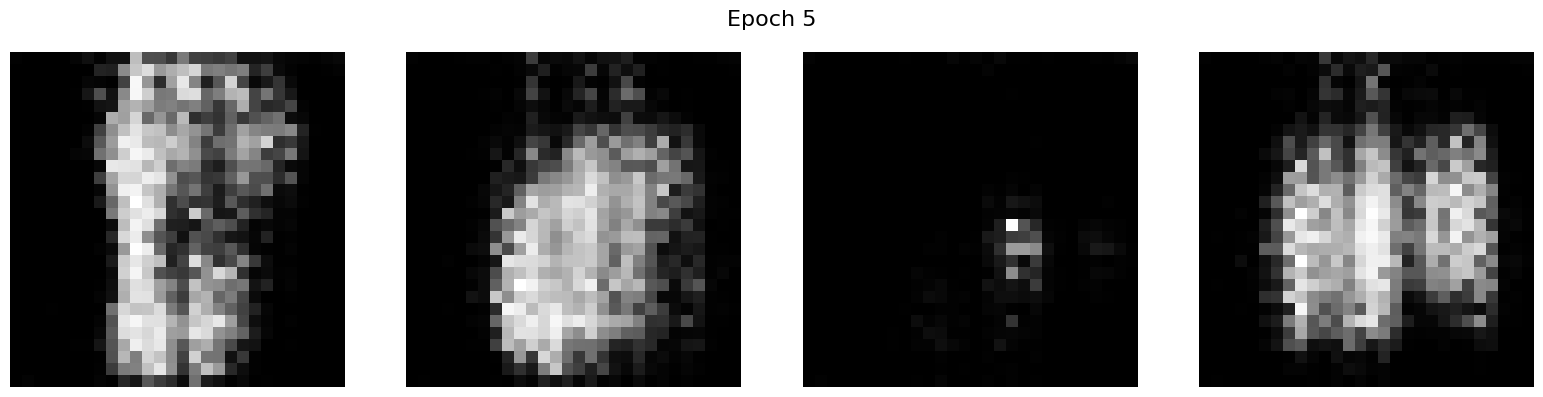

Epoch 6: 100%|██████████| 110/110 [00:43<00:00,  2.55it/s]



Epoch 6/100
Generator Loss: 1.3074
Discriminator Loss: 1.1871
Time: 43.13s


Epoch 7: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]



Epoch 7/100
Generator Loss: 1.2905
Discriminator Loss: 1.1953
Time: 42.33s


Epoch 8: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 8/100
Generator Loss: 1.2219
Discriminator Loss: 1.2267
Time: 81.91s


Epoch 9: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 9/100
Generator Loss: 1.2403
Discriminator Loss: 1.1976
Time: 81.91s


Epoch 10: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]


Epoch 10/100
Generator Loss: 1.2657
Discriminator Loss: 1.1655
Time: 81.91s


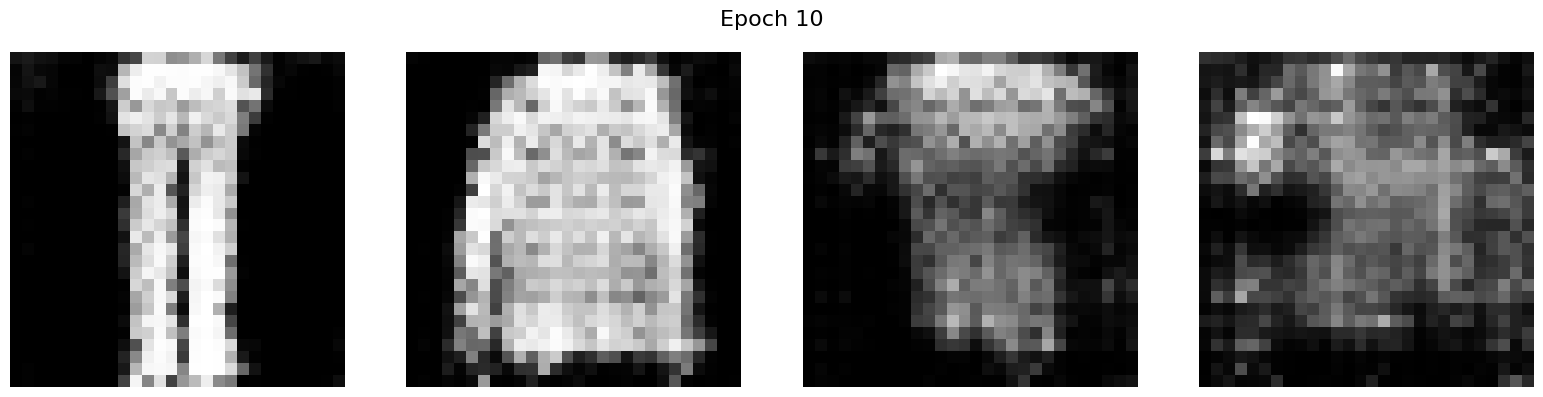

Epoch 11: 100%|██████████| 110/110 [00:43<00:00,  2.55it/s]



Epoch 11/100
Generator Loss: 1.2689
Discriminator Loss: 1.1563
Time: 43.12s


Epoch 12: 100%|██████████| 110/110 [00:42<00:00,  2.59it/s]



Epoch 12/100
Generator Loss: 1.2830
Discriminator Loss: 1.1509
Time: 42.52s


Epoch 13: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 13/100
Generator Loss: 1.2787
Discriminator Loss: 1.1495
Time: 81.91s


Epoch 14: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 14/100
Generator Loss: 1.2819
Discriminator Loss: 1.1503
Time: 81.91s


Epoch 15: 100%|██████████| 110/110 [00:43<00:00,  2.54it/s]


Epoch 15/100
Generator Loss: 1.3219
Discriminator Loss: 1.1344
Time: 43.26s


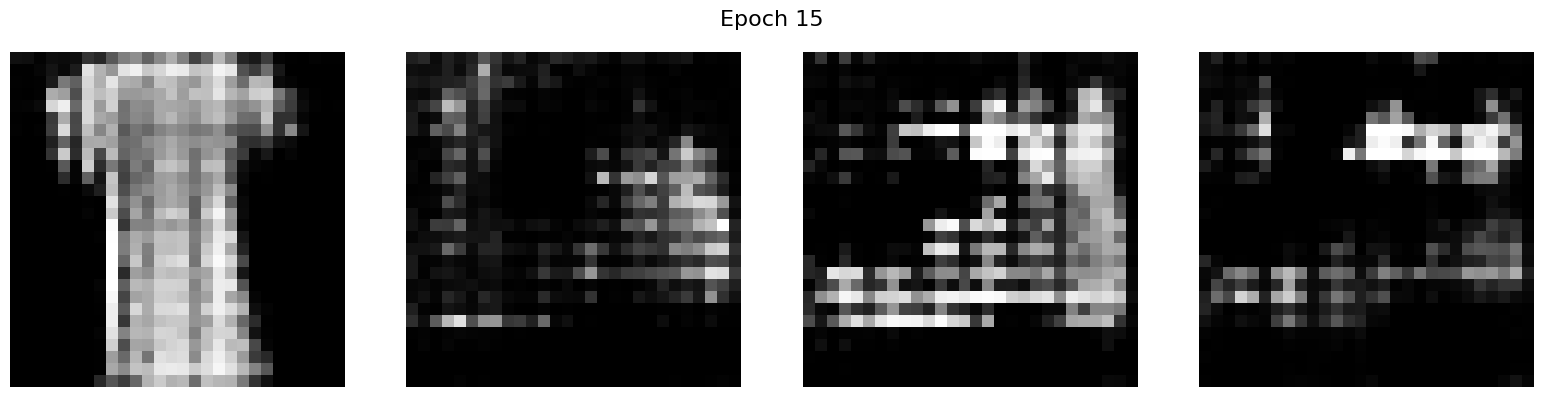

Epoch 16: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 16/100
Generator Loss: 1.3730
Discriminator Loss: 1.0919
Time: 81.91s


Epoch 17: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 17/100
Generator Loss: 1.3562
Discriminator Loss: 1.0875
Time: 81.91s


Epoch 18: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 18/100
Generator Loss: 1.3610
Discriminator Loss: 1.1021
Time: 81.91s


Epoch 19: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 19/100
Generator Loss: 1.3661
Discriminator Loss: 1.0971
Time: 81.91s


Epoch 20: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]


Epoch 20/100
Generator Loss: 1.3727
Discriminator Loss: 1.0796
Time: 42.32s


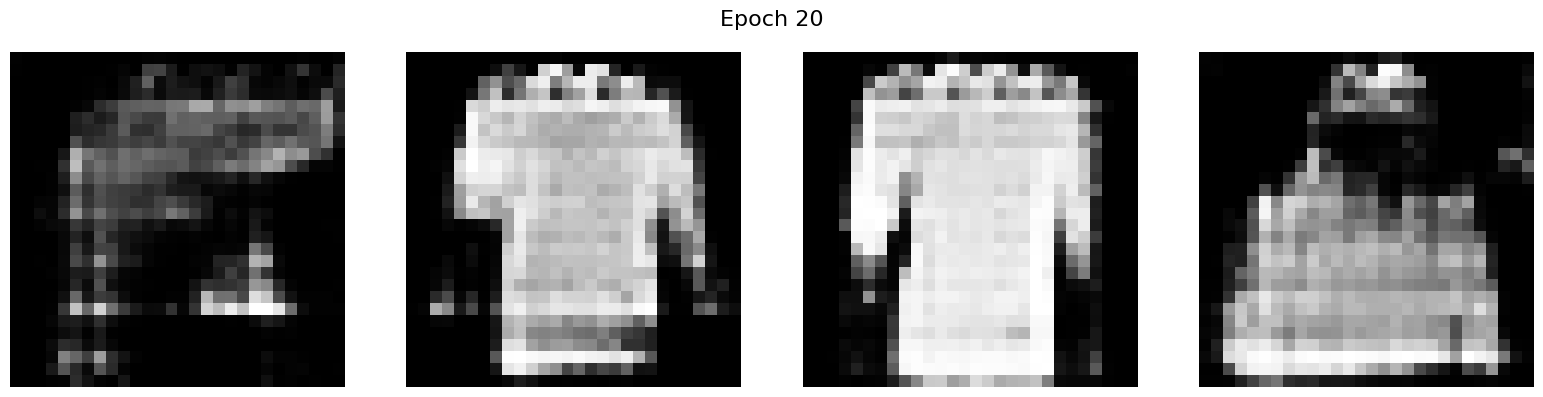

Epoch 21: 100%|██████████| 110/110 [00:43<00:00,  2.55it/s]



Epoch 21/100
Generator Loss: 1.3180
Discriminator Loss: 1.1403
Time: 43.09s


Epoch 22: 100%|██████████| 110/110 [00:42<00:00,  2.59it/s]



Epoch 22/100
Generator Loss: 1.2930
Discriminator Loss: 1.1410
Time: 42.44s


Epoch 23: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 23/100
Generator Loss: 1.2702
Discriminator Loss: 1.1516
Time: 81.91s


Epoch 24: 100%|██████████| 110/110 [00:43<00:00,  2.55it/s]



Epoch 24/100
Generator Loss: 1.2863
Discriminator Loss: 1.1372
Time: 43.19s


Epoch 25: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]


Epoch 25/100
Generator Loss: 1.2702
Discriminator Loss: 1.1539
Time: 81.91s


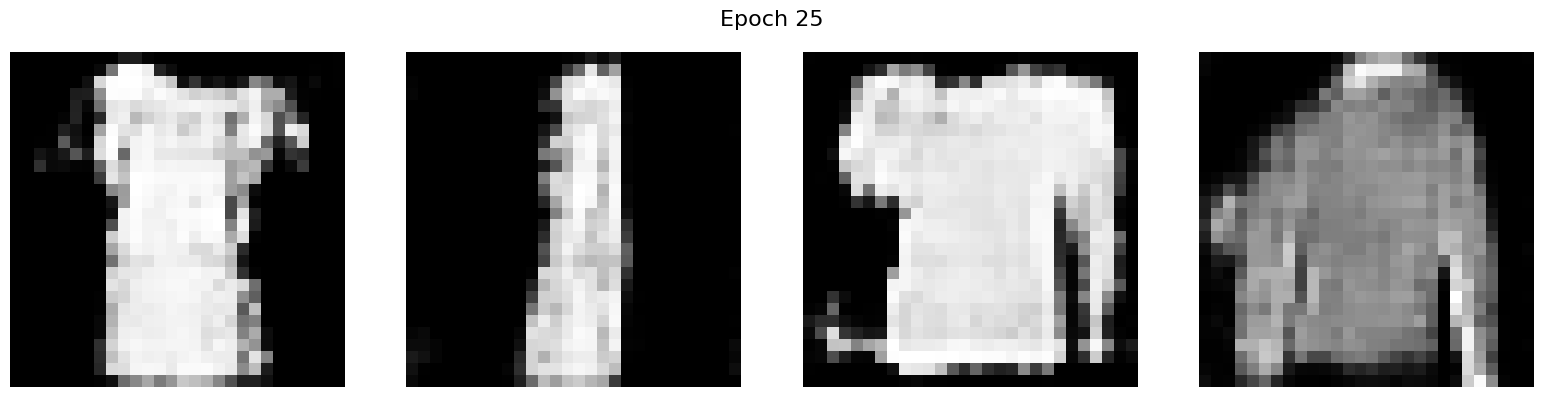

Epoch 26: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 26/100
Generator Loss: 1.2558
Discriminator Loss: 1.1722
Time: 81.92s


Epoch 27: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 27/100
Generator Loss: 1.2609
Discriminator Loss: 1.1508
Time: 81.91s


Epoch 28: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 28/100
Generator Loss: 1.2602
Discriminator Loss: 1.1507
Time: 81.91s


Epoch 29: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]



Epoch 29/100
Generator Loss: 1.2840
Discriminator Loss: 1.1345
Time: 42.31s


Epoch 30: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]


Epoch 30/100
Generator Loss: 1.2685
Discriminator Loss: 1.1513
Time: 42.82s


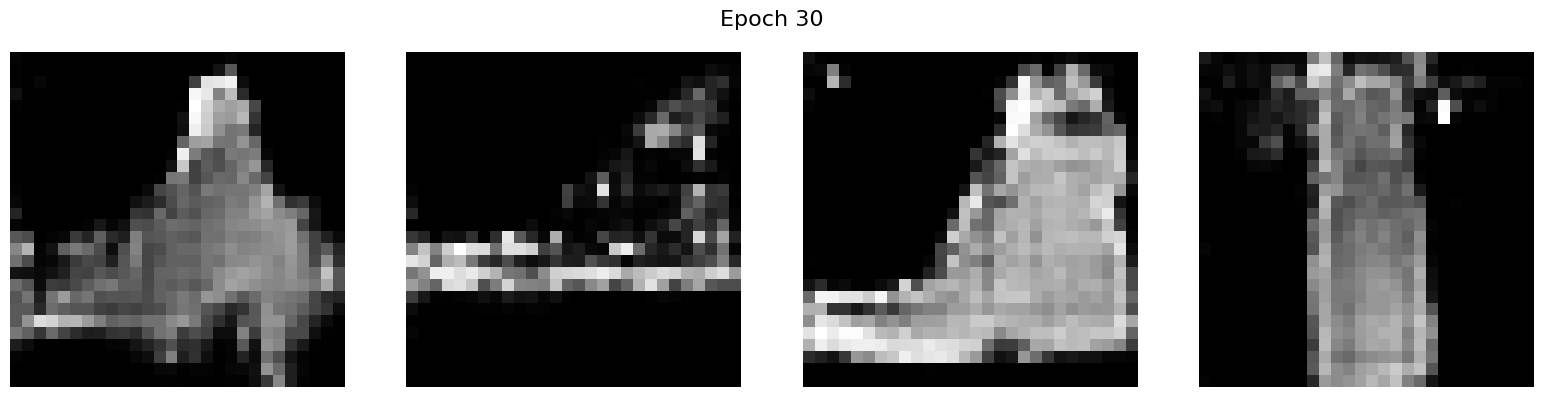

Epoch 31: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 31/100
Generator Loss: 1.2539
Discriminator Loss: 1.1733
Time: 81.91s


Epoch 32: 100%|██████████| 110/110 [00:42<00:00,  2.61it/s]



Epoch 32/100
Generator Loss: 1.2363
Discriminator Loss: 1.1643
Time: 42.17s


Epoch 33: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 33/100
Generator Loss: 1.2589
Discriminator Loss: 1.1486
Time: 81.91s


Epoch 34: 100%|██████████| 110/110 [00:43<00:00,  2.54it/s]



Epoch 34/100
Generator Loss: 1.2580
Discriminator Loss: 1.1565
Time: 43.24s


Epoch 35: 100%|██████████| 110/110 [00:42<00:00,  2.59it/s]


Epoch 35/100
Generator Loss: 1.2620
Discriminator Loss: 1.1401
Time: 42.46s


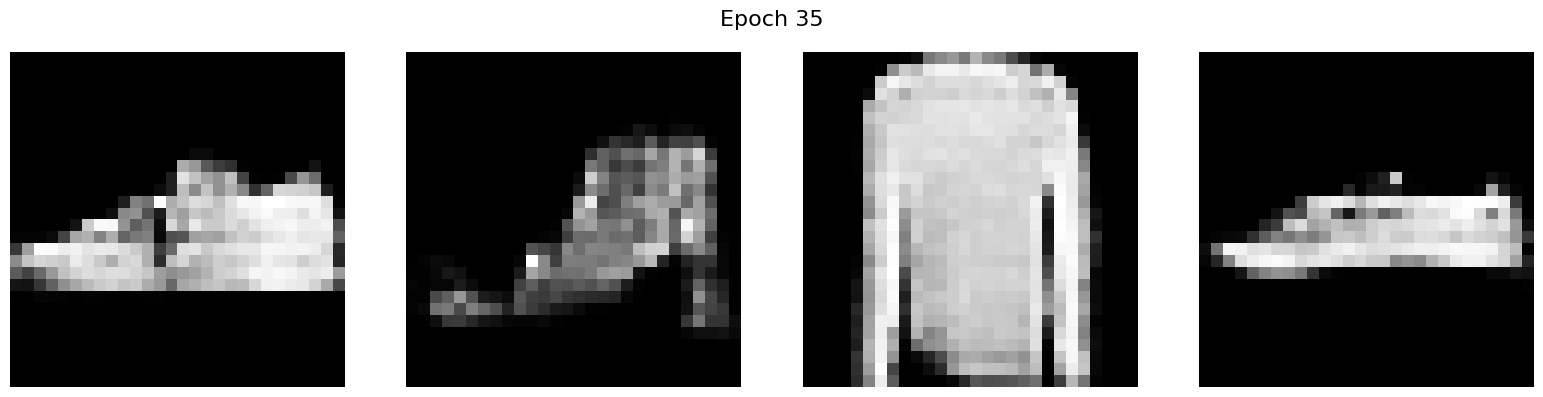

Epoch 36: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]



Epoch 36/100
Generator Loss: 1.2716
Discriminator Loss: 1.1395
Time: 42.86s


Epoch 37: 100%|██████████| 110/110 [00:42<00:00,  2.61it/s]



Epoch 37/100
Generator Loss: 1.2649
Discriminator Loss: 1.1463
Time: 42.08s


Epoch 38: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 38/100
Generator Loss: 1.2674
Discriminator Loss: 1.1461
Time: 81.92s


Epoch 39: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 39/100
Generator Loss: 1.2404
Discriminator Loss: 1.1728
Time: 81.91s


Epoch 40: 100%|██████████| 110/110 [00:42<00:00,  2.59it/s]


Epoch 40/100
Generator Loss: 1.2475
Discriminator Loss: 1.1599
Time: 42.51s


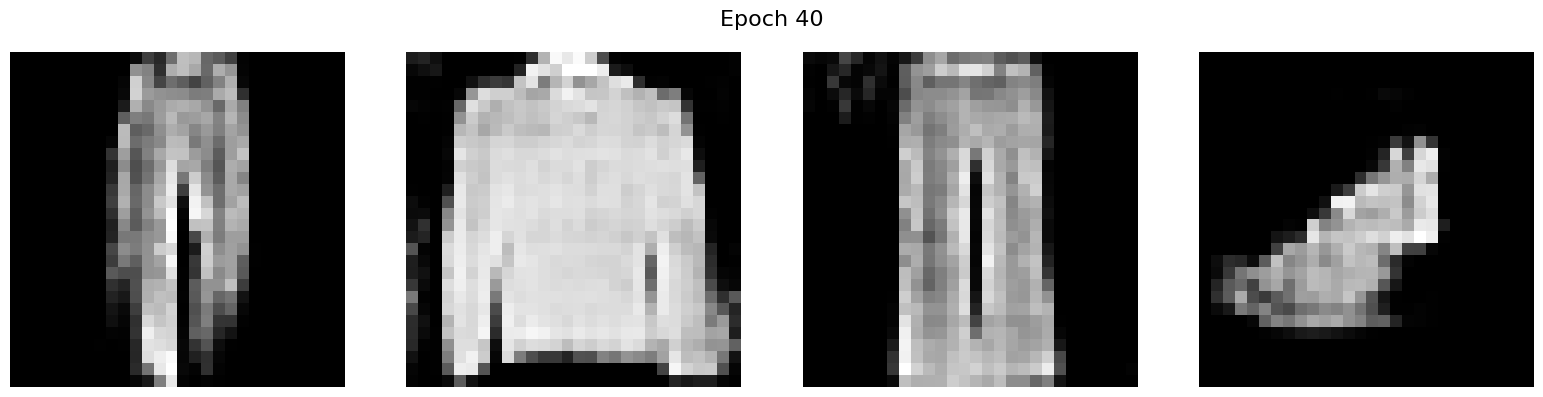

Epoch 41: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 41/100
Generator Loss: 1.2491
Discriminator Loss: 1.1651
Time: 81.91s


Epoch 42: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]



Epoch 42/100
Generator Loss: 1.2413
Discriminator Loss: 1.1653
Time: 42.79s


Epoch 43: 100%|██████████| 110/110 [00:42<00:00,  2.61it/s]



Epoch 43/100
Generator Loss: 1.2235
Discriminator Loss: 1.1842
Time: 42.17s


Epoch 44: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]



Epoch 44/100
Generator Loss: 1.2352
Discriminator Loss: 1.1664
Time: 42.78s


Epoch 45: 100%|██████████| 110/110 [00:41<00:00,  2.62it/s]


Epoch 45/100
Generator Loss: 1.2529
Discriminator Loss: 1.1562
Time: 41.96s


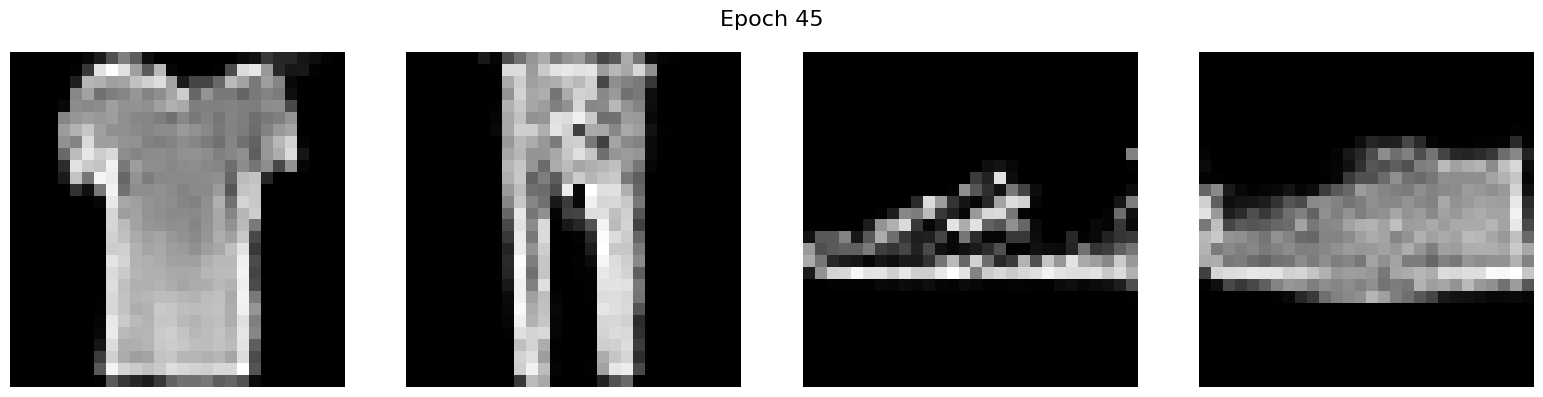

Epoch 46: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 46/100
Generator Loss: 1.2539
Discriminator Loss: 1.1485
Time: 81.91s


Epoch 47: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 47/100
Generator Loss: 1.2633
Discriminator Loss: 1.1527
Time: 81.91s


Epoch 48: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]



Epoch 48/100
Generator Loss: 1.2757
Discriminator Loss: 1.1399
Time: 42.76s


Epoch 49: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]



Epoch 49/100
Generator Loss: 1.2573
Discriminator Loss: 1.1594
Time: 42.33s


Epoch 50: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]


Epoch 50/100
Generator Loss: 1.2722
Discriminator Loss: 1.1420
Time: 81.91s


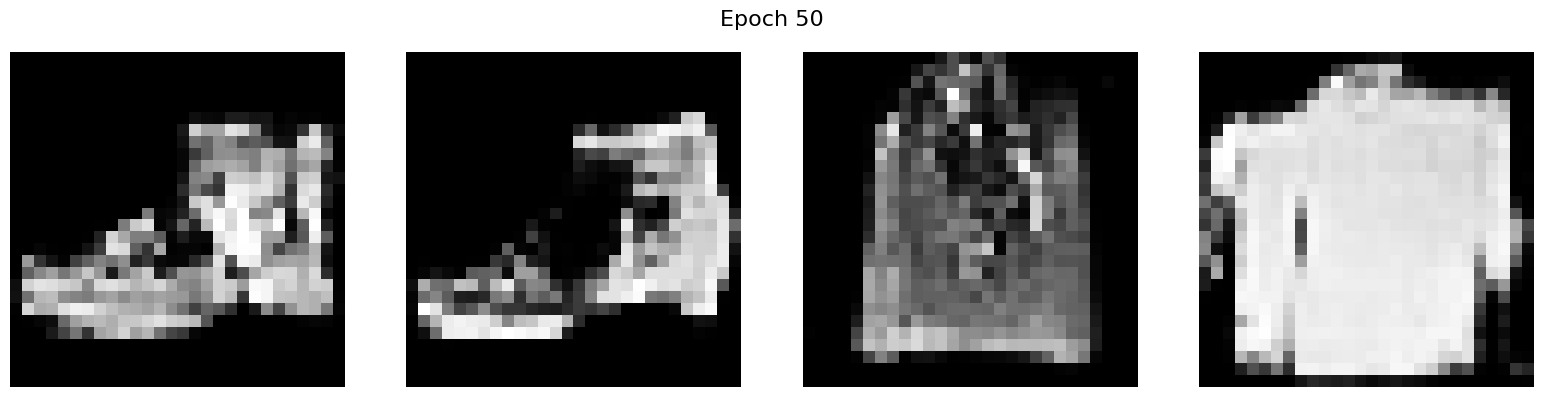

Epoch 51: 100%|██████████| 110/110 [00:42<00:00,  2.59it/s]



Epoch 51/100
Generator Loss: 1.2870
Discriminator Loss: 1.1275
Time: 42.49s


Epoch 52: 100%|██████████| 110/110 [00:41<00:00,  2.63it/s]



Epoch 52/100
Generator Loss: 1.2984
Discriminator Loss: 1.1377
Time: 41.91s


Epoch 53: 100%|██████████| 110/110 [00:42<00:00,  2.56it/s]



Epoch 53/100
Generator Loss: 1.2738
Discriminator Loss: 1.1531
Time: 42.89s


Epoch 54: 100%|██████████| 110/110 [00:42<00:00,  2.62it/s]



Epoch 54/100
Generator Loss: 1.2852
Discriminator Loss: 1.1331
Time: 42.05s


Epoch 55: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]


Epoch 55/100
Generator Loss: 1.3130
Discriminator Loss: 1.1182
Time: 81.91s


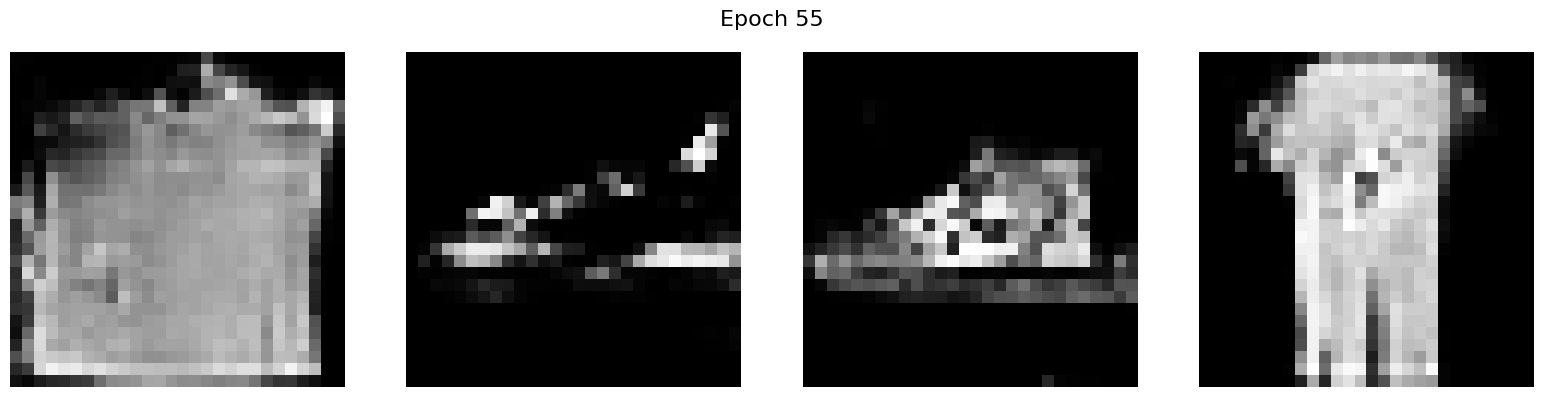

Epoch 56: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]



Epoch 56/100
Generator Loss: 1.2710
Discriminator Loss: 1.1461
Time: 42.62s


Epoch 57: 100%|██████████| 110/110 [00:42<00:00,  2.62it/s]



Epoch 57/100
Generator Loss: 1.2989
Discriminator Loss: 1.1356
Time: 42.06s


Epoch 58: 100%|██████████| 110/110 [00:42<00:00,  2.56it/s]



Epoch 58/100
Generator Loss: 1.2881
Discriminator Loss: 1.1405
Time: 43.00s


Epoch 59: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 59/100
Generator Loss: 1.2934
Discriminator Loss: 1.1333
Time: 81.92s


Epoch 60: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]


Epoch 60/100
Generator Loss: 1.3119
Discriminator Loss: 1.1321
Time: 42.78s


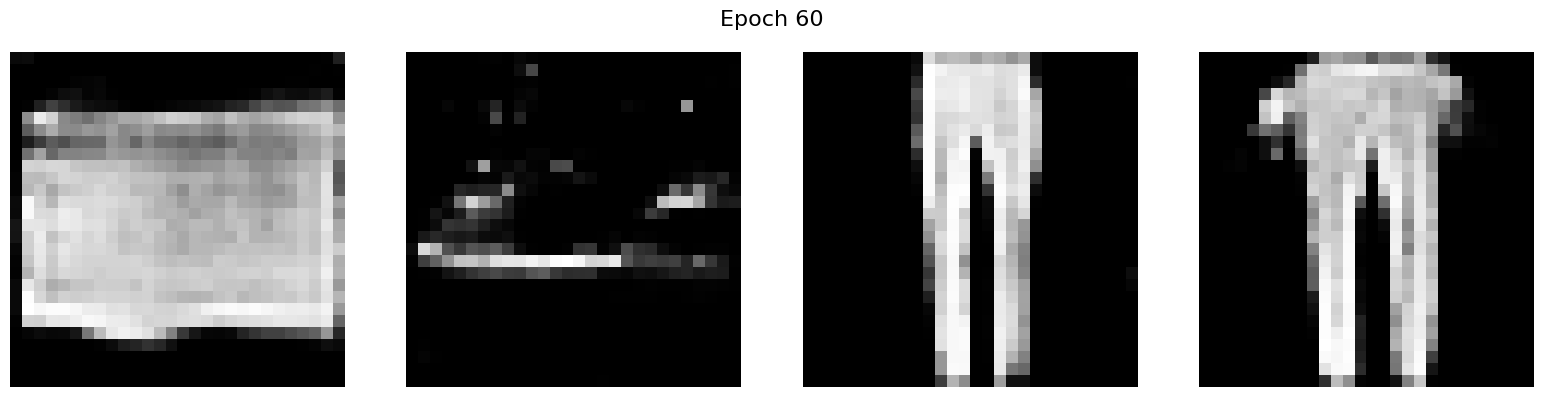

Epoch 61: 100%|██████████| 110/110 [00:43<00:00,  2.52it/s]



Epoch 61/100
Generator Loss: 1.3097
Discriminator Loss: 1.1195
Time: 43.63s


Epoch 62: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]



Epoch 62/100
Generator Loss: 1.3061
Discriminator Loss: 1.1268
Time: 42.83s


Epoch 63: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 63/100
Generator Loss: 1.3084
Discriminator Loss: 1.1407
Time: 81.91s


Epoch 64: 100%|██████████| 110/110 [00:43<00:00,  2.54it/s]



Epoch 64/100
Generator Loss: 1.3093
Discriminator Loss: 1.1220
Time: 43.35s


Epoch 65: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]


Epoch 65/100
Generator Loss: 1.3078
Discriminator Loss: 1.1356
Time: 81.91s


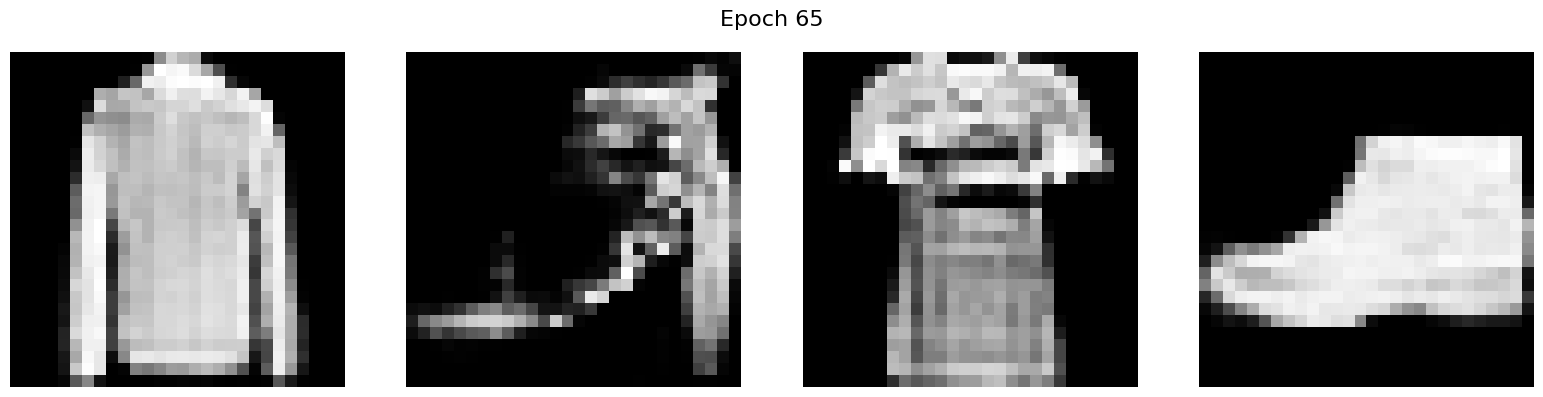

Epoch 66: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]



Epoch 66/100
Generator Loss: 1.3293
Discriminator Loss: 1.1226
Time: 42.57s


Epoch 67: 100%|██████████| 110/110 [00:41<00:00,  2.63it/s]



Epoch 67/100
Generator Loss: 1.3430
Discriminator Loss: 1.1057
Time: 41.89s


Epoch 68: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 68/100
Generator Loss: 1.3498
Discriminator Loss: 1.1067
Time: 81.91s


Epoch 69: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 69/100
Generator Loss: 1.3170
Discriminator Loss: 1.1267
Time: 81.91s


Epoch 70: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]


Epoch 70/100
Generator Loss: 1.3269
Discriminator Loss: 1.1208
Time: 42.62s


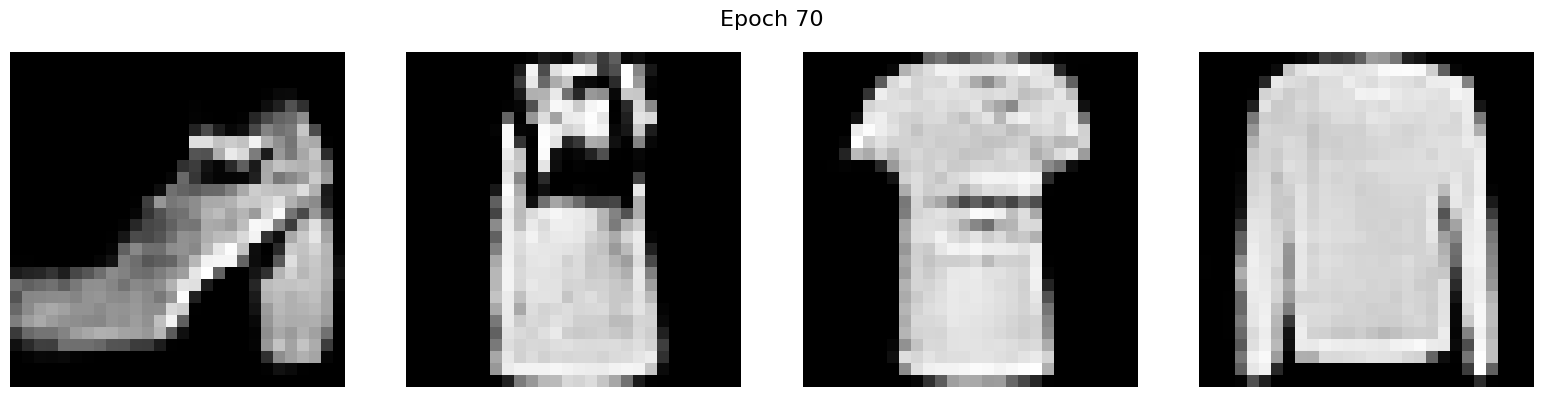

Epoch 71: 100%|██████████| 110/110 [00:41<00:00,  2.62it/s]



Epoch 71/100
Generator Loss: 1.3210
Discriminator Loss: 1.1370
Time: 41.95s


Epoch 72: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 72/100
Generator Loss: 1.3457
Discriminator Loss: 1.1177
Time: 81.91s


Epoch 73: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]



Epoch 73/100
Generator Loss: 1.3593
Discriminator Loss: 1.1144
Time: 42.63s


Epoch 74: 100%|██████████| 110/110 [00:41<00:00,  2.62it/s]



Epoch 74/100
Generator Loss: 1.3194
Discriminator Loss: 1.1398
Time: 42.00s


Epoch 75: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]


Epoch 75/100
Generator Loss: 1.3446
Discriminator Loss: 1.1040
Time: 81.91s


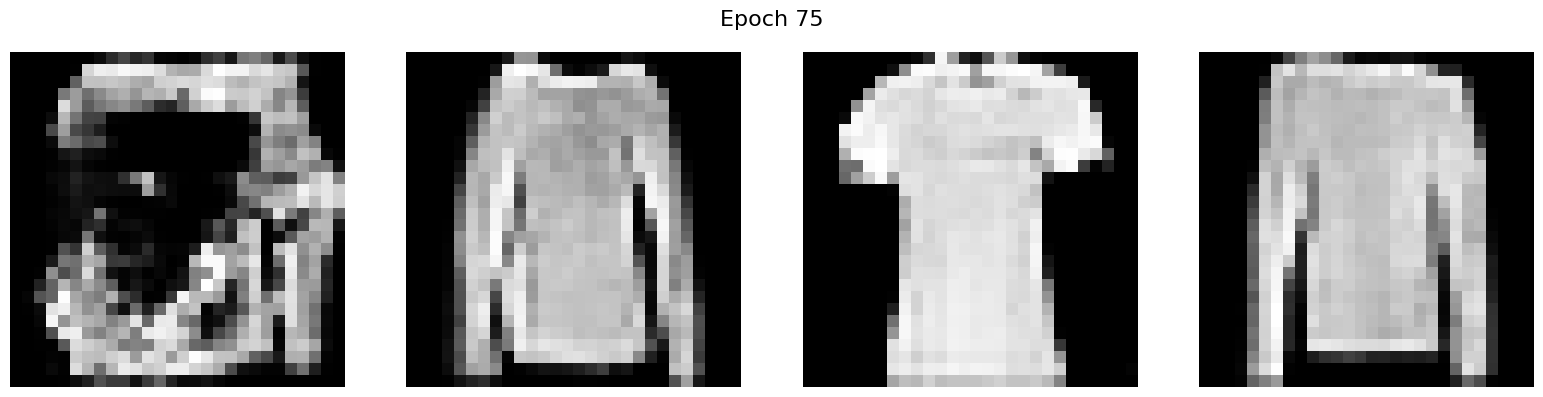

Epoch 76: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 76/100
Generator Loss: 1.3585
Discriminator Loss: 1.1097
Time: 81.91s


Epoch 77: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 77/100
Generator Loss: 1.3351
Discriminator Loss: 1.1134
Time: 81.91s


Epoch 78: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]



Epoch 78/100
Generator Loss: 1.3494
Discriminator Loss: 1.1371
Time: 42.30s


Epoch 79: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 79/100
Generator Loss: 1.3486
Discriminator Loss: 1.1058
Time: 81.91s


Epoch 80: 100%|██████████| 110/110 [00:42<00:00,  2.56it/s]


Epoch 80/100
Generator Loss: 1.3249
Discriminator Loss: 1.1446
Time: 42.92s


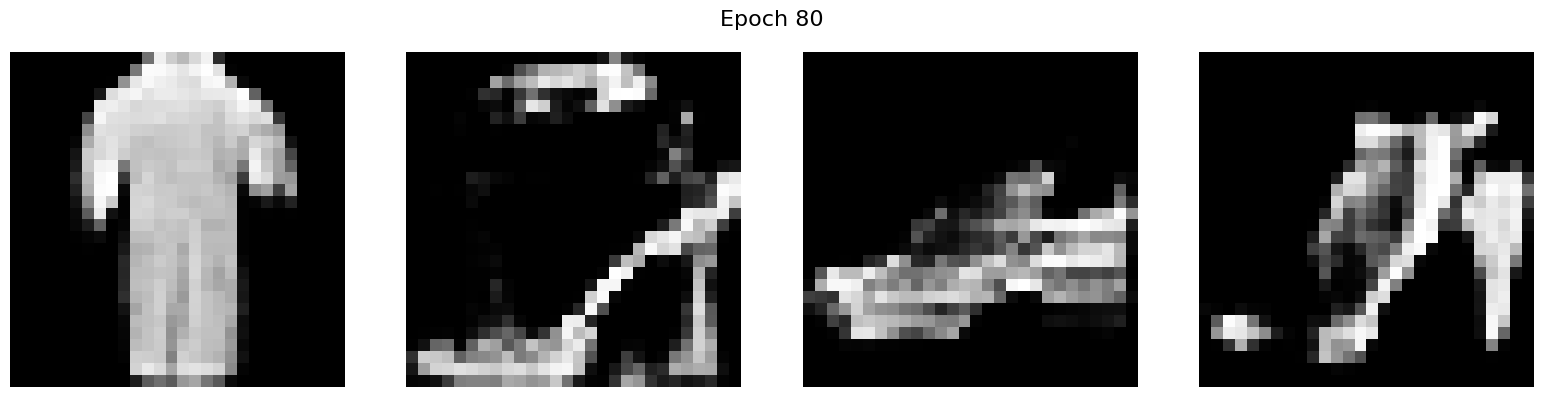

Epoch 81: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 81/100
Generator Loss: 1.3603
Discriminator Loss: 1.1288
Time: 81.91s


Epoch 82: 100%|██████████| 110/110 [00:41<00:00,  2.64it/s]



Epoch 82/100
Generator Loss: 1.3072
Discriminator Loss: 1.1386
Time: 41.69s


Epoch 83: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 83/100
Generator Loss: 1.3456
Discriminator Loss: 1.1043
Time: 81.91s


Epoch 84: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 84/100
Generator Loss: 1.3338
Discriminator Loss: 1.1150
Time: 81.91s


Epoch 85: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]


Epoch 85/100
Generator Loss: 1.3301
Discriminator Loss: 1.1409
Time: 42.65s


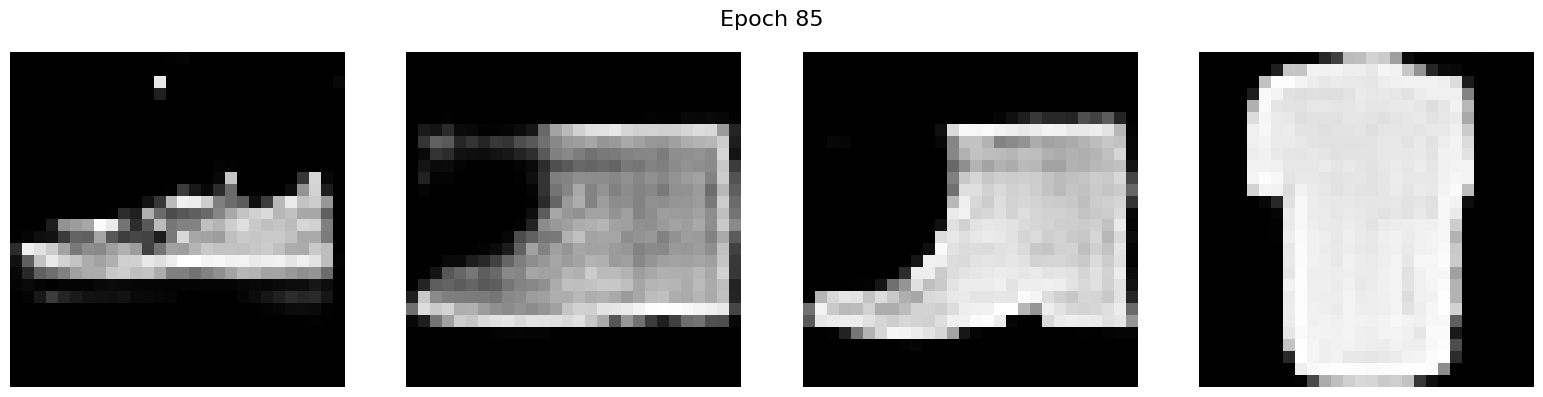

Epoch 86: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 86/100
Generator Loss: 1.3525
Discriminator Loss: 1.1120
Time: 81.91s


Epoch 87: 100%|██████████| 110/110 [00:41<00:00,  2.63it/s]



Epoch 87/100
Generator Loss: 1.3376
Discriminator Loss: 1.1227
Time: 41.80s


Epoch 88: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]



Epoch 88/100
Generator Loss: 1.3307
Discriminator Loss: 1.1493
Time: 42.28s


Epoch 89: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 89/100
Generator Loss: 1.3455
Discriminator Loss: 1.1178
Time: 81.91s


Epoch 90: 100%|██████████| 110/110 [00:41<00:00,  2.62it/s]


Epoch 90/100
Generator Loss: 1.3554
Discriminator Loss: 1.1135
Time: 42.00s


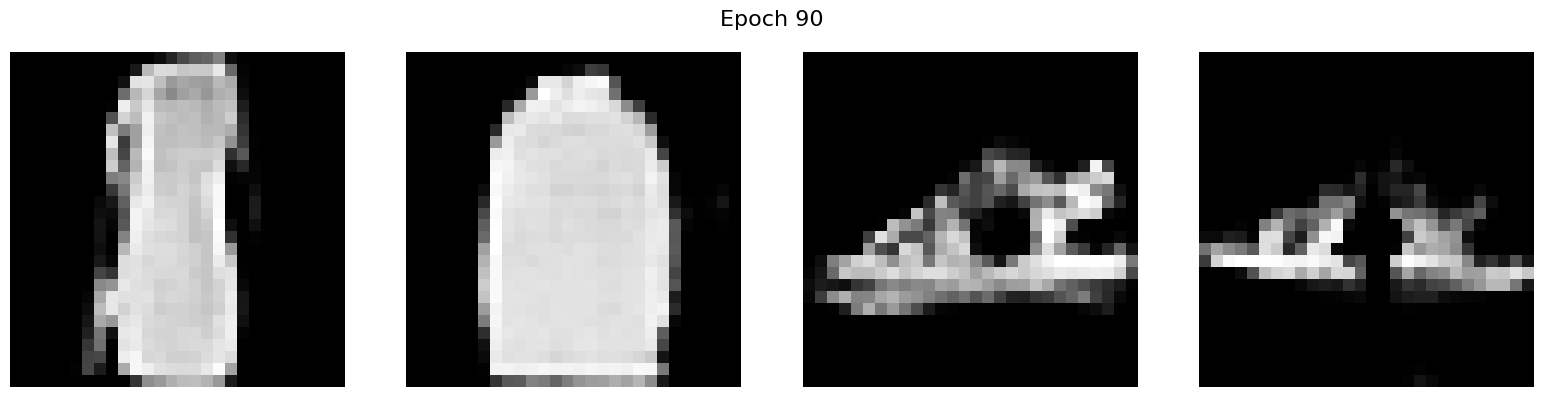

Epoch 91: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 91/100
Generator Loss: 1.3398
Discriminator Loss: 1.1198
Time: 81.91s


Epoch 92: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 92/100
Generator Loss: 1.4031
Discriminator Loss: 1.0777
Time: 81.91s


Epoch 93: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 93/100
Generator Loss: 1.3318
Discriminator Loss: 1.1360
Time: 81.91s


Epoch 94: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 94/100
Generator Loss: 1.3488
Discriminator Loss: 1.1228
Time: 81.91s


Epoch 95: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]


Epoch 95/100
Generator Loss: 1.3714
Discriminator Loss: 1.1180
Time: 81.91s


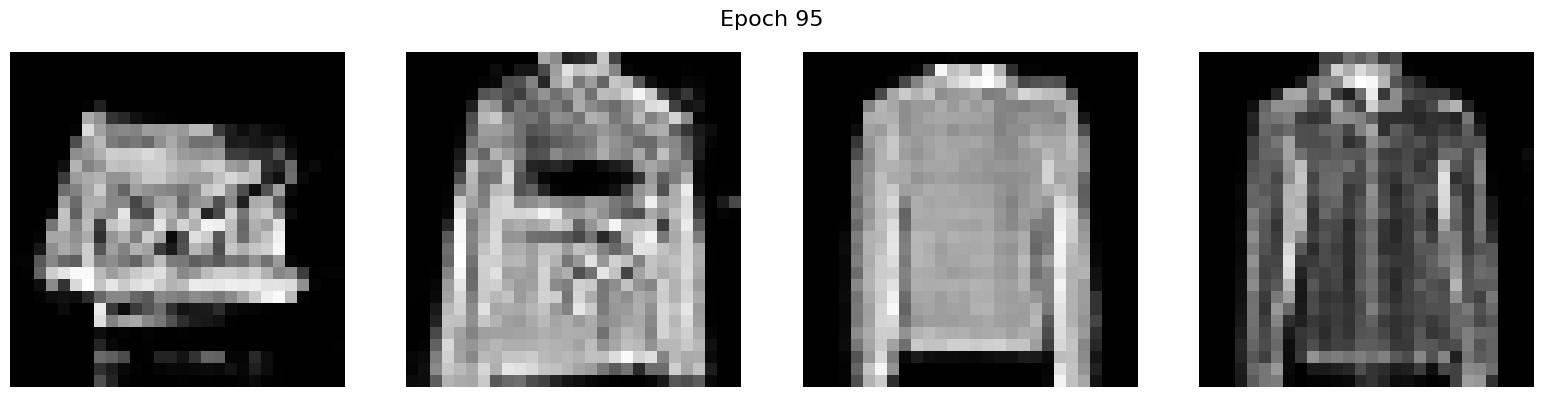

Epoch 96: 100%|██████████| 110/110 [00:42<00:00,  2.60it/s]



Epoch 96/100
Generator Loss: 1.3898
Discriminator Loss: 1.0915
Time: 42.36s


Epoch 97: 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]



Epoch 97/100
Generator Loss: 1.3859
Discriminator Loss: 1.1032
Time: 42.85s


Epoch 98: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 98/100
Generator Loss: 1.3744
Discriminator Loss: 1.1116
Time: 81.92s


Epoch 99: 100%|██████████| 110/110 [01:21<00:00,  1.34it/s]



Epoch 99/100
Generator Loss: 1.4148
Discriminator Loss: 1.0719
Time: 81.91s


Epoch 100: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]


Epoch 100/100
Generator Loss: 1.3903
Discriminator Loss: 1.0966
Time: 42.62s


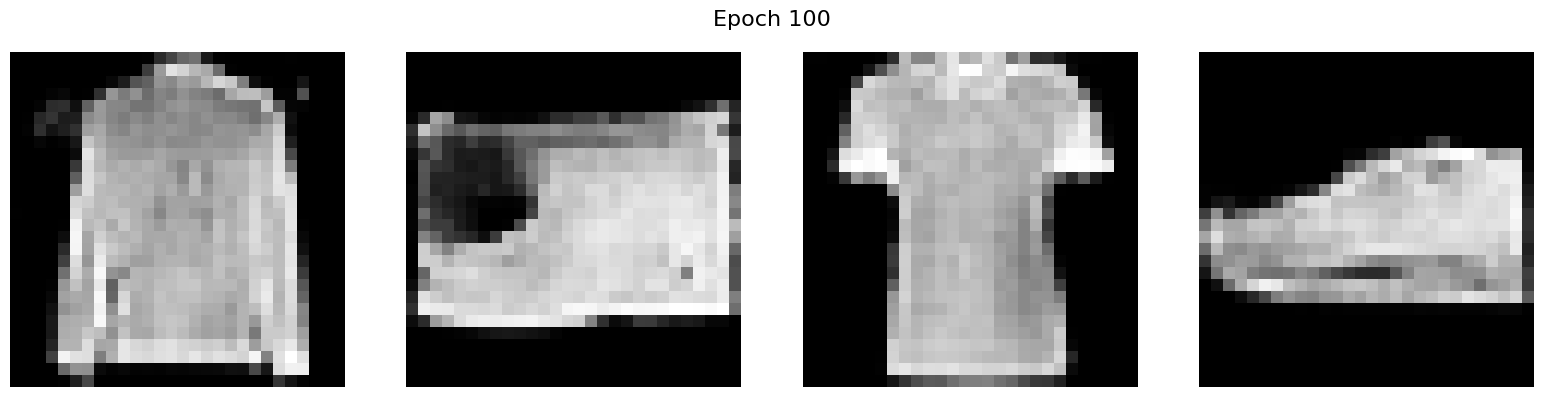

In [ ]:
G, D = train(EPOCHS, train_dataset, generator=generator, discriminator=discriminator)

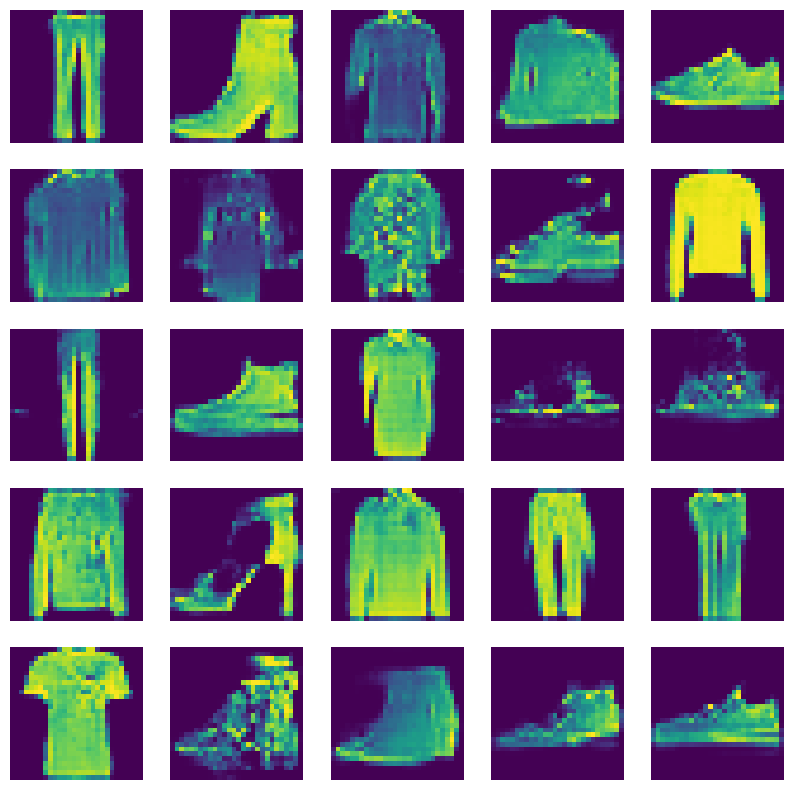

In [ ]:
plot_generated_images(5)